# Mini Hydrogen Case Study

```{mermaid}
graph LR
    %% --- INPUTS ---
    subgraph Inputs [Supply Chain Inputs]
        NG[Natural Gas]
        BIO[Biomass]
        ELEC[Renewable Electricity]
        CO2_PS[CO2: Point Source]
        CO2_DAC[CO2: Direct Air Capture]
    end

    %% --- PATHWAYS ---
    subgraph Tech [Conversion Technology]
        SMR[Steam Methane Reforming]
        GAS[Gasification]
        ELECTRO[Electrolysis]
        CAP[Carbon Capture]
    end

    %% --- SYNTHESIS ---
    subgraph Synthesis [Methanol Synthesis]
        TRAD[Traditional Reactor]
        HYDRO[CO2 Hydrogenation]
    end

    %% --- CONNECTIONS WITH LABELS ---
    NG -- "CH4 Feed" --> SMR
    SMR -- "Syngas (H2 rich) + CO2 byproduct" --> TRAD
    
    BIO -- "Solid Feed" --> GAS
    GAS -- "Raw Syngas (CO rich) + Biochar, Tar & Ash" --> TRAD
    
    ELEC --> ELECTRO
    ELECTRO -- "Pure H2 (+ O2 byproduct)" --> HYDRO
    
    CO2_PS --> CAP
    CO2_DAC --> CAP
    CAP -- "Pure CO2" --> HYDRO

    %% --- OUTPUT ---
    TRAD -- "Crude MeOH + H2O" --> MEOH[Methanol Product]
    HYDRO -- "Crude MeOH + H2O" --> MEOH
````

In [30]:
import bw2data as bd
from datetime import datetime

In [31]:
bd.projects.set_current("optimex_test")

In [32]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

Products:

In [33]:
methanol = foreground.new_node(
    name="methanol",
    code="methanol",
    unit="kg",
    type=bd.labels.product_node_default,
)
methanol.save()

hydrogen = foreground.new_node(
    name="hydrogen",
    code="hydrogen",
    unit="kg",
    type=bd.labels.product_node_default,
)
hydrogen.save()

captured_co2 = foreground.new_node(
    name="captured CO2",
    code="captured_co2",
    unit="kg",
    type=bd.labels.product_node_default,
)
captured_co2.save()

Processes:

In [34]:
def productify(background_node, new_product_node, foreground_db_name="foreground", process_name=None, process_location="GLO", operation_time_limits=(0,10)):
    """
    Copies a background process to the foreground database as a new process producing a new, 
    explicit product. Keeps all non-production exchanges the unchanged. Essentially turning a 
    "processwithreferenceproduct" into a "process". Products need to be created as new nodes 
    beforehand.
    """
    assert (
        len(background_node.production()) == 1
    ), "Multifunctional process, not sure what to do"

    fg = bd.Database(foreground_db_name)

    new_name = process_name if process_name else background_node["name"]
    new_location = process_location if process_location else background_node["location"]
    
    new_process_node = fg.new_node(
        name=new_name,
        code=new_name,
        location=new_location,
        type=bd.labels.process_node_default,
    )

    new_process_node.new_edge(
        input=new_product_node,
        amount=1.0,
        type=bd.labels.production_edge_default,
    ).save()    

    for exc in background_node.technosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.consumption_edge_default,
        ).save()

    for exc in background_node.biosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.biosphere_edge_default,
        ).save()

    new_process_node["operation_time_limits"] = operation_time_limits
    new_process_node.save()
    return new_process_node

In [35]:
bg_dac = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured, with a solvent-based direct air capture system, 1MtCO2", location="RER")
bg_cc_steel = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured at steel production plant, using vacuum pressure swing adsorption", location="EUR")
bg_meoh_biomass_gasification = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="methanol production, biomass gasification", location="EUR")
bg_meoh_ng = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="methanol production, from natural gas reforming", location="RER")

cc_steel = productify(bg_cc_steel, captured_co2, process_name="carbon capture at steel plant", process_location="RER")
dac = productify(bg_dac, captured_co2, process_name="direct air capture", process_location="RER")
# meoh_biomass_gasification = productify(bg_meoh_biomass_gasification, methanol, process_name="methanol from biomass gasification", process_location="RER")
meoh_ng = productify(bg_meoh_ng, methanol, process_name="methanol from natural gas", process_location="RER", operation_time_limits=(0,20))

# productify(bg_meoh_biomass_gasification, methanol, process_name="methanol from biomass gasification", process_location="EUR")
# productify(bg_meoh_wood_ccs, methanol, process_name="methanol from wood with CCS", process_location="RER")
# productify(bg_meoh_ng, methanol, process_name="methanol from natural gas", process_location="RER")
# productify(bg_meoh_h2_cement, methanol, process_name="methanol from H2 and cement CO2", process_location="RER")


In [36]:
for process in [cc_steel, dac, meoh_ng]:
    for exc in process.exchanges():
        exc["operation"] = True
        exc.save()

In [37]:
bg_h2_pem = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", location="EUR")
h2_pem = productify(bg_h2_pem, hydrogen, process_name="hydrogen from PEM electrolysis", process_location="EUR")

In [38]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution
import numpy as np

In [39]:
h2_pem["operation_time_limits"] = (0, 8)
for exc in h2_pem.exchanges():
    if "electrolyzer production" in exc.input["name"].lower():
        exc["temporal_distribution"] = TemporalDistribution(
            date=np.array([0], dtype="timedelta64[Y]"), amount=np.array([1])
        )
    elif "treatment of electrolyzer" in exc.input["name"].lower():
        exc["temporal_distribution"] = TemporalDistribution(
            date=np.array([8], dtype="timedelta64[Y]"), amount=np.array([1])
        )
    else:
        exc["temporal_distribution"] = easy_timedelta_distribution(
            start=0, end=8, steps=9, kind="uniform", resolution="Y"
        )
        exc["operation"] = True
    exc.save()
h2_pem.save()

In [40]:
bg_meoh_h2 = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="methanol synthesis, hydrogen from electrolysis, CO2 from DAC", location="RER")

In [41]:
meoh_from_h2 = foreground.new_node(
    name="methanol production from hydrogen and captured CO2",
    code="methanol production from hydrogen and captured CO2",
    location="RER",
    type=bd.labels.process_node_default,
)
meoh_from_h2.save()

meoh_from_h2.new_edge(
    input=methanol,
    amount=1.0,
    type=bd.labels.production_edge_default,
).save()

for exc in bg_meoh_h2.technosphere():
    if "carbon dioxide, captured" in exc.input["name"].lower():
        meoh_from_h2.new_edge(
            input=captured_co2,
            amount=exc.amount,
            type=bd.labels.consumption_edge_default,
        ).save()
        continue
    
    if "hydrogen production" in exc.input["name"].lower():
        meoh_from_h2.new_edge(
            input=hydrogen,
            amount=exc.amount,
            type=bd.labels.consumption_edge_default,
        ).save()
        continue
    
    meoh_from_h2.new_edge(
        input=exc.input,
        amount=exc.amount,
        type=bd.labels.consumption_edge_default,
    ).save()
    
for exc in bg_meoh_h2.biosphere():
    meoh_from_h2.new_edge(
        input=exc.input,
        amount=exc.amount,
        type=bd.labels.biosphere_edge_default,
    ).save()

In [42]:
meoh_from_h2.save()

In [43]:
meoh_from_h2["operation_time_limits"] = (0, 10)
for exc in meoh_from_h2.exchanges():
    if "production facitilty" in exc.input["name"].lower():
        exc["temporal_distribution"] = TemporalDistribution(
            date=np.array([0], dtype="timedelta64[Y]"), amount=np.array([1])
        )
    elif "treatment" in exc.input["name"].lower():
        exc["temporal_distribution"] = TemporalDistribution(
            date=np.array([10], dtype="timedelta64[Y]"), amount=np.array([1])
        )
    else:
        exc["temporal_distribution"] = easy_timedelta_distribution(start=0, end=10, steps=11, kind="uniform", resolution="Y")
        exc["operation"] = True
    exc.save()
meoh_from_h2.save()

In [44]:
dbs = {
    2020: bd.Database("ei311_REMIND_SSP2_PkBudg650_2020"),
    # 2030: bd.Database("ei311_REMIND_SSP2_PkBudg650_2030"),
    # 2040: bd.Database("ei311_REMIND_SSP2_PkBudg650_2040"),
    2050: bd.Database("ei311_REMIND_SSP2_PkBudg650_2050"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

In [45]:
# exchanges = list(dac.technosphere()) + list(cc_steel.technosphere()) + list(meoh_from_h2.technosphere())

# for exc in exchanges:
#     node=exc.input
#     if node["database"] == bd.Database("ecoinvent-3.11-biosphere").name:
#         continue
#     if node["type"] != bd.labels.chimaera_node_default:
#         continue
#     for db in dbs.values():
#         node_in_other_db = db.get(
#             name=node["name"],
#             product=node.get("reference product", None),
#             location=node["location"],
#         )
#         if node["code"] != node_in_other_db["code"]:
#             node_in_other_db["code"] = node["code"]
#             node_in_other_db.save()

In [46]:
from bw_temporalis import TemporalDistribution
import numpy as np

years = range(2025, 2075)
rng = np.random.default_rng(25)

trend = np.linspace(10, 20, len(years))
noise = rng.normal(0, 4.0, len(years))
amount = trend + noise

td_demand = TemporalDistribution(
    date=np.array(
        [datetime(year, 1, 1).isoformat() for year in years],
        dtype="datetime64[s]",
    ),
    amount=amount,
)

functional_demand = {methanol: td_demand}

In [47]:
from optimex import lca_processor

method = (
    "ecoinvent-3.11",
    "IPCC 2021 (incl. biogenic CO2) no LT",
    "climate change: total (incl. biogenic CO2) no LT",
    "global warming potential (GWP100) no LT",
)

# method = (
#     "ecoinvent-3.11",
#     "EF v3.1 no LT",
#     "climate change no LT",
#     "global warming potential (GWP100) no LT",
# )

lca_config = lca_processor.LCAConfig(
    demand=functional_demand,
    temporal={
        "start_date": datetime(2015, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            # "metric": "CRF",  # CRF
        },
    ],
)

In [48]:
from optimex import converter

lca_data_processor = lca_processor.LCADataProcessor(lca_config)
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

2025-12-19 14:31:11.189 | INFO     | optimex.lca_processor:_parse_demand:385 - Identified demand in system time range of %s for products %s
2025-12-19 14:31:11.210 | INFO     | optimex.lca_processor:_construct_foreground_tensors:521 - Constructed foreground tensors.
2025-12-19 14:31:11.211 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Technosphere (external) shape: (5 processes, 31 flows, 11 years) with 114 total entries.
2025-12-19 14:31:11.211 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Internal demand shape: (1 processes, 2 flows, 11 years) with 22 total entries.
2025-12-19 14:31:11.211 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Biosphere shape: (5 processes, 14 flows, 11 years) with 59 total entries.
2025-12-19 14:31:11.211 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Production shape: (5 processes, 3 flows, 11 years) with 23 total entries.
2025-12-19 14:31:11.212 | INFO     | optimex.lca_processor:_calculate

In [49]:
manager.save("model_inputs.json") # if you want to save the model inputs to a file

In [50]:
from optimex import converter
manager = converter.ModelInputManager()

manager.load("model_inputs.json") # if you want to load the model inputs from a file

OptimizationModelInputs(PROCESS=['direct air capture', 'hydrogen from PEM electrolysis', 'methanol from natural gas', 'methanol production from hydrogen and captured CO2', 'carbon capture at steel plant'], PRODUCT=['methanol', 'captured_co2', 'hydrogen'], INTERMEDIATE_FLOW=['6472fc53a2b74eed98e6e06ff326c7c9', '1a85747c6d5844faa0c47b75c9e6949e', '959253aa67e4411aa0ebe9f9fd50cfb8', 'bda2da73bdff4e6b97a4b61ba03a0565', 'b945619580294dc9a24e1faf2c725101', '8217978abd97463a857422df9def824e', 'ac346e4d58584fe6826ba780a85f4d8c', '3162b762c6fb4680a5fc0c2b965e4175', '1b956500866b481589be118e83820fdc', '0d4a5ee595b7409385a22fd0d037731f', '287f2c42cda849b5abe57c9244b36991', '8e4e7279ceb54f7d85aeeb1d5e3bd4c7', '643e0309b5d740fe920ca11baa652ef1', 'bf38c5aecc9e4888bf1f199c905de08b', '2a73b344e023432086b99c17c47be8dd', 'b503593ad86f4e3fbb80091624ae83a1', '4938fc8eed684a53bd4f128baccca4be', '5377ee98b02c44b8a5a6cc155485b2c2', '6971dfbe9a63424f9e70e64078beb96a', '56db83b0434d41cf86e8940176b1f9bd', '5dac

In [51]:
cc_steel_limit = {(cc_steel["code"], t): 10 for t in manager.model_inputs.SYSTEM_TIME}
existing_meoh_ng_capacities = {(meoh_ng["code"], 2014): 20}
optimization_model_inputs = manager.override(process_operation_limits_max=cc_steel_limit, existing_capacity=existing_meoh_ng_capacities)

In [52]:
from optimex import optimizer

model = optimizer.create_model(
    manager.model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
)

2025-12-19 14:32:11.140 | INFO     | optimex.optimizer:create_model:124 - Creating sets
2025-12-19 14:32:11.142 | INFO     | optimex.optimizer:create_model:166 - Creating parameters
2025-12-19 14:32:11.240 | INFO     | optimex.optimizer:create_model:383 - Creating variables


In [53]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-12-19 14:34:35.171 | INFO     | optimex.optimizer:solve_model:771 - Solver [glpk] termination: optimal
2025-12-19 14:35:46.180 | INFO     | optimex.optimizer:solve_model:796 - Objective (scaled): -0.0970741
2025-12-19 14:35:46.188 | INFO     | optimex.optimizer:solve_model:797 - Objective (real):   -932.726


In [54]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

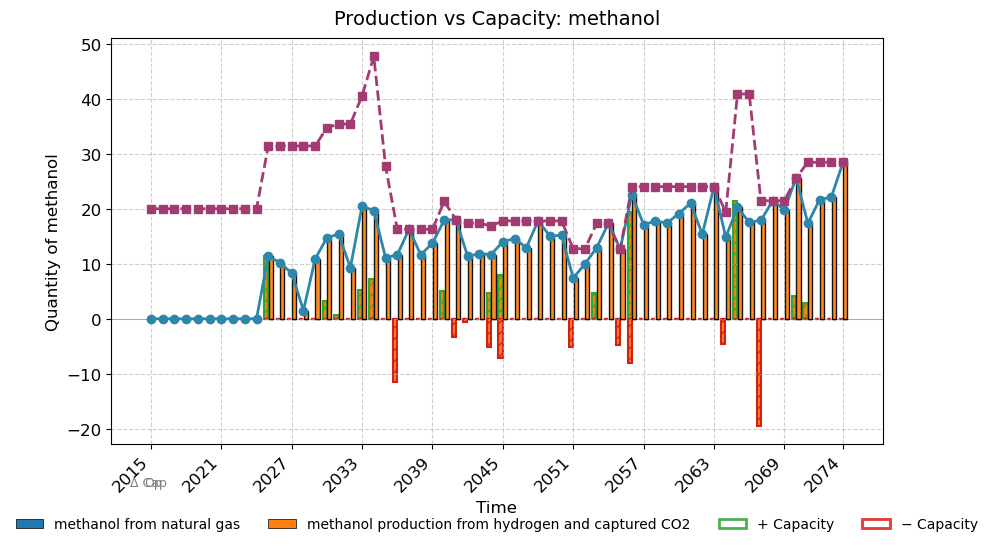

In [55]:
pp.plot_production_vs_capacity(show_grouped_bars=True)

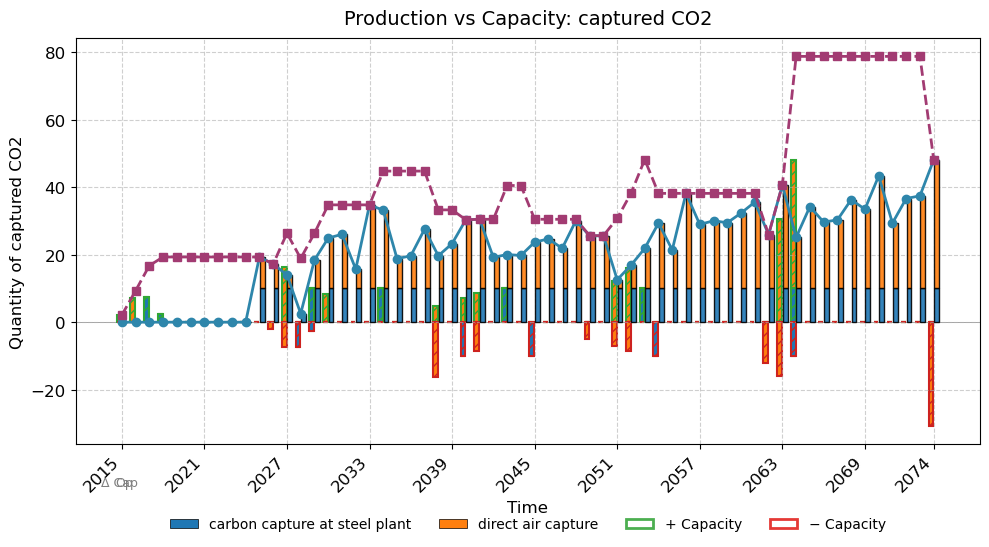

In [28]:
pp.plot_production_vs_capacity(show_grouped_bars=True, product="captured_co2")

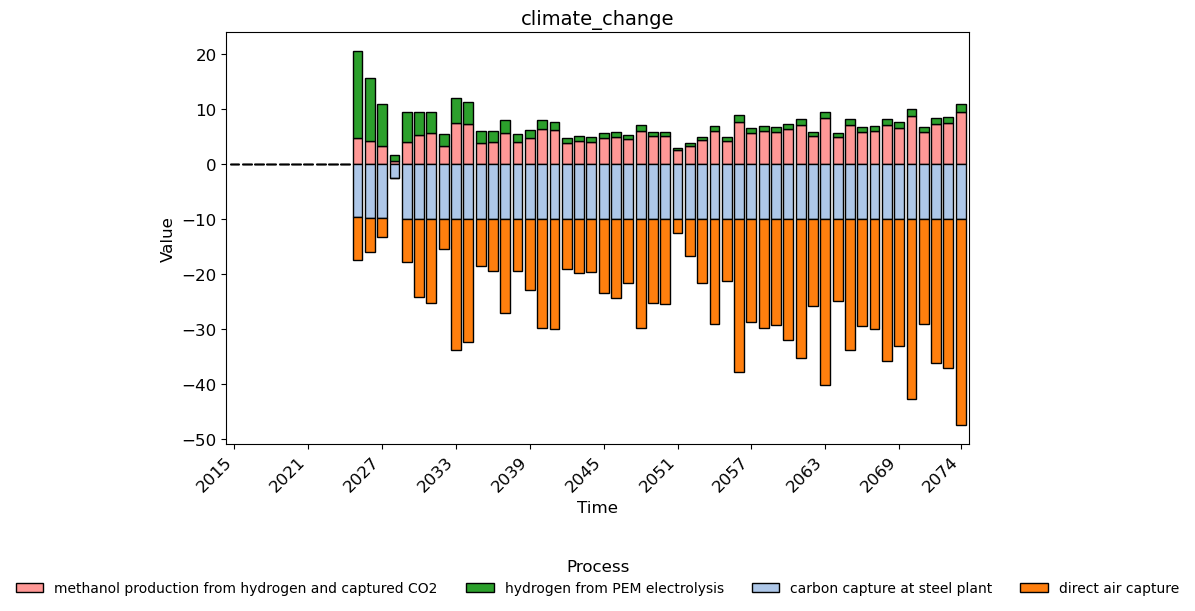

In [29]:
pp.plot_impacts()

In [116]:
pp.get_installation()

Process  3c3303b0cad047b5a0c6d39ec74f3323  carbon capture at steel plant  \
Time                                                                       
2015                             0.000000                            1.0   
2016                             0.000000                            1.0   
2017                             0.000000                            1.0   
2018                             0.000000                            1.0   
2019                             0.000000                            1.0   
2020                             0.000000                            1.0   
2021                             3.291337                            1.0   
2022                             0.000000                            1.0   
2023                             0.938606                            1.0   
2024                             0.000000                            1.0   
2025                             7.186216                            1.0   
2026                             0.000000                            1.0   
2027                             0.000000                            1.0   
2028                             0.000000                            1.0   
2029                             0.000000                            1.0   
2030                             3.313725                            1.0   
2031                             0.667945                            1.0   
2032                             0.000000                            1.0   
2033                             8.443617                            1.0   
2034                             0.000000                            1.0   
2035                             0.000000                            1.0   
2036                             1.650327                            1.0   
2037                             2.209226                            1.0   
2038                             0.000000                            1.0   
2039                             0.000000                            1.0   
2040                             7.821804                            1.0   
2041                             0.000000                            1.0   
2042                             0.000000                            1.0   
2043                             0.000000                            1.0   
2044                             0.000000                            1.0   
2045                             2.343643                            1.0   
2046                             0.560374                            1.0   
2047                             0.000000                            1.0   
2048                             7.066833                            1.0   
2049                             0.000000                            1.0   
2050                             0.000000                            1.0   
2051                             0.000000                            1.0   
2052                             0.000000                            1.0   
2053                             2.962535                            1.0   
2054                             4.426807                            1.0   
2055                             0.000000                            1.0   
2056                            10.029285                            1.0   
2057                             0.000000                            1.0   
2058                             0.000000                            1.0   
2059                             0.000000                            1.0   
2060                             3.624226                            1.0   
2061                             0.000000                            1.0   
2062                             0.000000                            1.0   
2063                             2.986384                            1.0   
2064                            28.448422                            1.0   
2065                             0.000000       

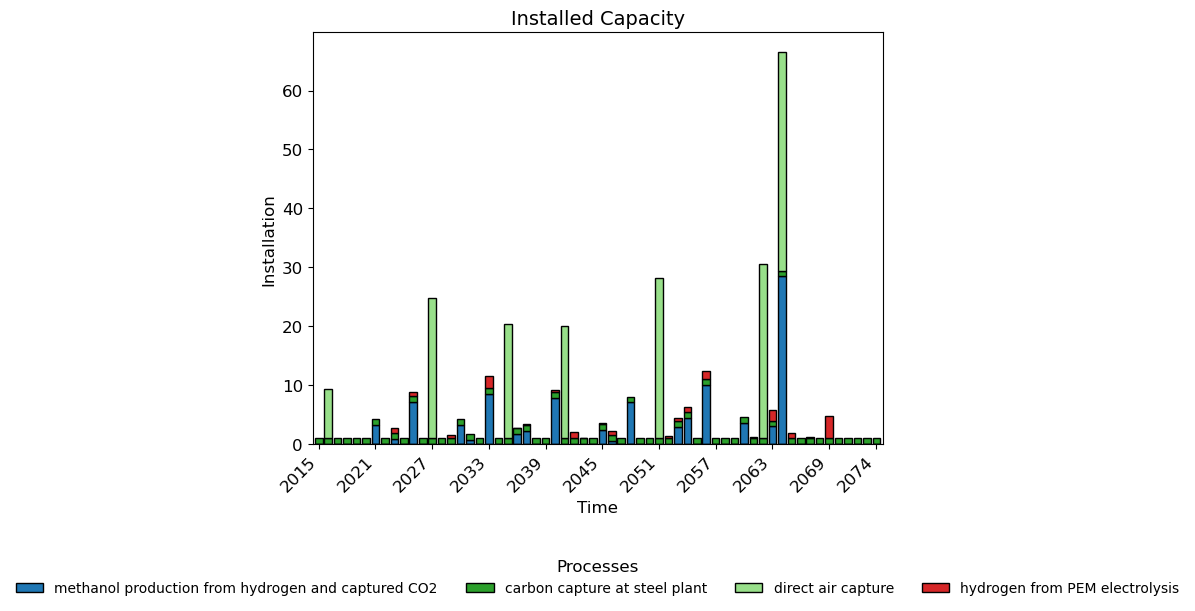

In [115]:
pp.plot_installation()

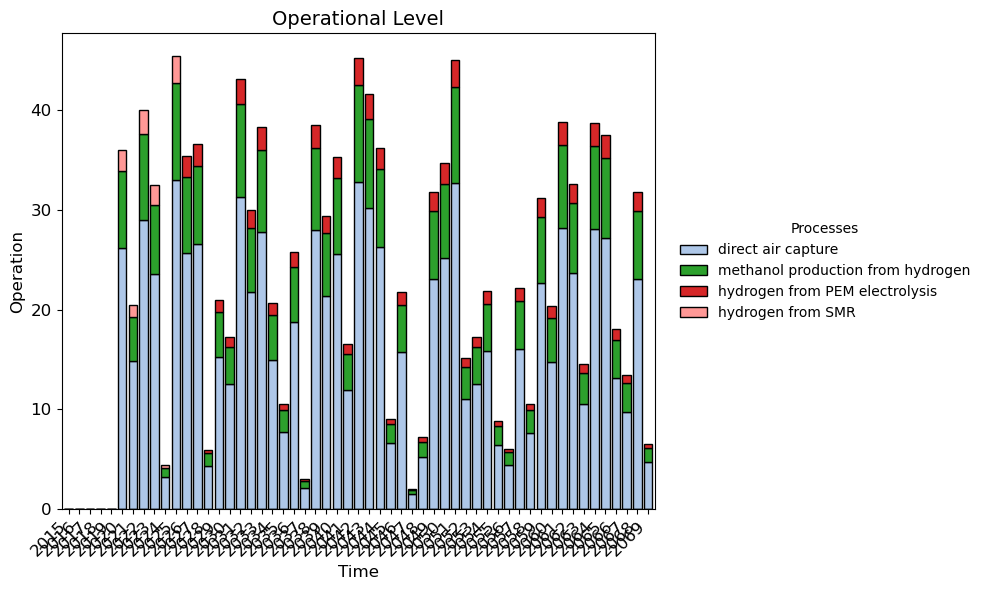

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [55]:
pp.plot_operation()

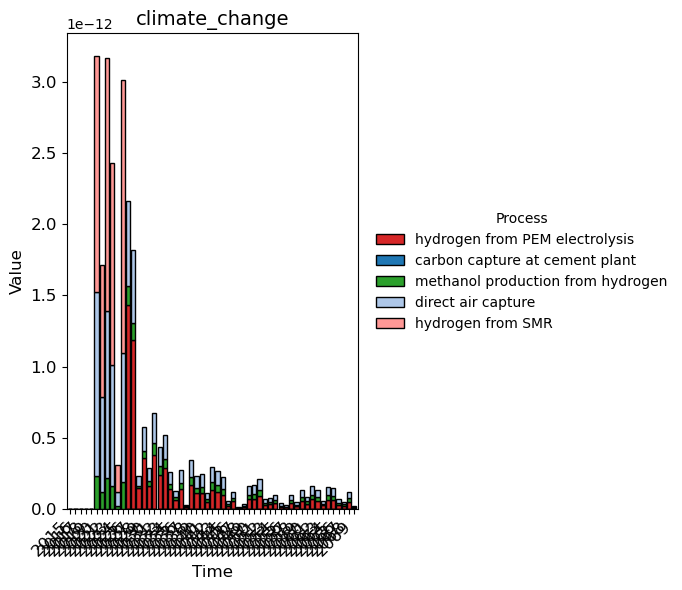

(<Figure size 1000x600 with 1 Axes>,
 array([<Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>,
        <Axes: xlabel='Time', ylabel='Value'>], dtype=object))

In [54]:
pp.plot_impacts()

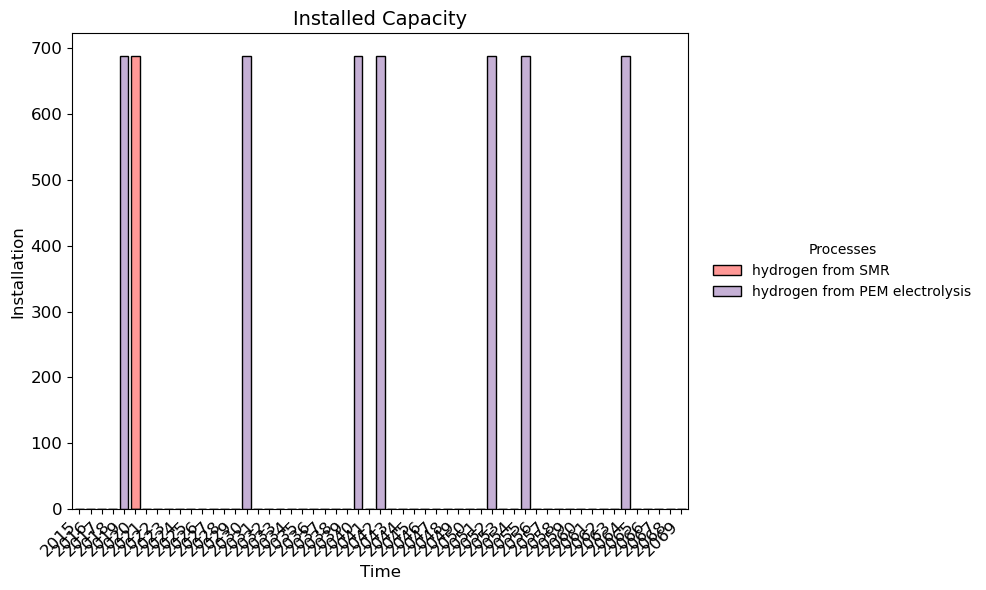

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [36]:
pp.plot_installation()

In [328]:
m.scales

{'foreground': 4.909090909090909,
 'characterization': {'climate_change': 2.3348057260696622e-11}}

In [30]:
model.scales

{'foreground': 4.909090909090909,
 'characterization': {'climate_change': 2.3348057260696622e-11}}

In [29]:
pp.get_operation()

Process  693b3d79849340fd9f8af7a47041607c  dac305c0bdeb4e6d8fcde37f622240d0
Time                                                                       
2015                                  0.0                               0.0
2016                                  0.0                               0.0
2017                                  0.0                               0.0
2018                                  0.0                               0.0
2019                                  0.0                               0.0
2020                                  0.0                             540.0
2021                                  0.0                             540.0
2022                                  0.0                             540.0
2023                                  0.0                             540.0
2024                                  0.0                             540.0
2025                                  0.0                             540.0
2026                                540.0                               0.0
2027                                540.0                               0.0
2028                                540.0                               0.0
2029                                540.0                               0.0
2030                                540.0                               0.0
2031                                540.0                               0.0
2032                                540.0                               0.0
2033                                540.0                               0.0
2034                                540.0                               0.0
2035                                540.0                               0.0
2036                                540.0                               0.0
2037                                540.0                               0.0
2038                                540.0                               0.0
2039                                540.0                               0.0
2040                                540.0                               0.0
2041                                540.0                               0.0
2042                                540.0                               0.0
2043                                540.0                               0.0
2044                                540.0                               0.0
2045                                540.0                               0.0
2046                                540.0                               0.0
2047                                540.0                               0.0
2048                                540.0                               0.0
2049                                540.0                               0.0
2050                                540.0                               0.0
2051                                540.0                               0.0
2052                                540.0                               0.0
2053                                540.0                               0.0
2054                                540.0                               0.0
2055                                540.0                               0.0
2056                                540.0                               0.0
2057                                540.0                               0.0
2058                                540.0                               0.0
2059                                540.0                               0.0
2060                                540.0                               0.0
2061                                540.0                               0.0
2062                                540.0                               0.0
2063                                540.0                               0.0
2064                                540.0                               0.0
2065                                540.0       

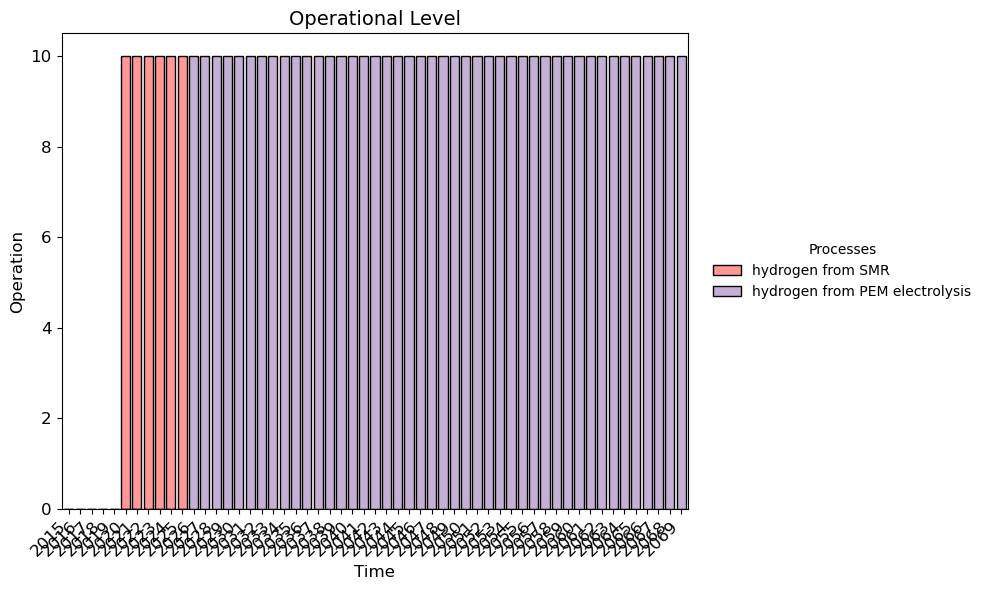

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [37]:
pp.plot_operation()

# --------------------------

### Plotting the resulting radiative forcing 

In [319]:
import pyomo.environ as pyo 
fg_scale = getattr(pp.m, "scales", {}).get("foreground", 1.0)
inventory = {
    (p, e, t): pyo.value(pp.m.scaled_inventory[p, e, t]) * fg_scale
    for p in pp.m.PROCESS
    for e in pp.m.ELEMENTARY_FLOW
    for t in pp.m.SYSTEM_TIME
}

import pandas as pd

dynamic_inventory_df = pd.DataFrame.from_records(
    [(p, e, t, v) for (p, e, t), v in inventory.items()],
    columns=["activity", "flow", "date", "amount"]
).astype({
    "activity": "str",
    "flow": "str",
    # "date": "datetime64[s]",
    "amount": "float64"
})

dynamic_inventory_df['date'] = pd.to_datetime(dynamic_inventory_df['date'].astype(int), format='%Y')

In [320]:
dynamic_inventory_df

activity                                  flow  \
0      a5d2821e34c24d078e8efdd93b289405  e3e8f6a2-c45e-4685-9859-698b2eadaf5b   
1      a5d2821e34c24d078e8efdd93b289405  e3e8f6a2-c45e-4685-9859-698b2eadaf5b   
2      a5d2821e34c24d078e8efdd93b289405  e3e8f6a2-c45e-4685-9859-698b2eadaf5b   
3      a5d2821e34c24d078e8efdd93b289405  e3e8f6a2-c45e-4685-9859-698b2eadaf5b   
4      a5d2821e34c24d078e8efdd93b289405  e3e8f6a2-c45e-4685-9859-698b2eadaf5b   
...                                 ...                                   ...   
92945  34fe9823ae894b6882216398c2ce9029  dcedc211-8daa-49ac-82a9-ce60a22d9b43   
92946  34fe9823ae894b6882216398c2ce9029  dcedc211-8daa-49ac-82a9-ce60a22d9b43   
92947  34fe9823ae894b6882216398c2ce9029  dcedc211-8daa-49ac-82a9-ce60a22d9b43   
92948  34fe9823ae894b6882216398c2ce9029  dcedc211-8daa-49ac-82a9-ce60a22d9b43   
92949  34fe9823ae894b6882216398c2ce9029  dcedc211-8daa-49ac-82a9-ce60a22d9b43   

            date  amount  
0     2015-01-01     0.0  
1     2016-01-01     0.0  
2     2017-01-01     0.0  
3     2018-01-01     0.0  
4     2019-01-01     0.0  
...          ...     ...  
92945 2065-01-01     0.0  
92946 2066-01-01     0.0  
92947 2067-01-01     0.0  
92948 2068-01-01     0.0  
92949 2069-01-01     0.0  

[92950 rows x 4 columns]

In [321]:
dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
    lambda x: bd.Database("ecoinvent-3.11-biosphere").get(code=x).id
)

In [324]:
from dynamic_characterization import characterize

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        base_lcia_method=method,
        time_horizon=100,
        fixed_time_horizon=True,
)

2025-12-10 17:27:58.254 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


<Axes: xlabel='date_rounded'>

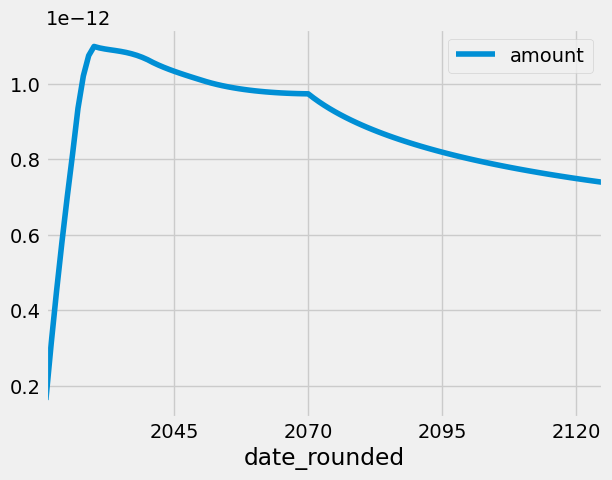

In [326]:
df_characterized['date'] = pd.to_datetime(df_characterized['date'])
df_grouped = (
    df_characterized
    .assign(date_rounded=(df_characterized['date'] + pd.offsets.MonthBegin(6)).dt.to_period('Y').dt.to_timestamp())
    .groupby('date_rounded')['amount'].sum()
    .reset_index()
)

df_grouped.plot(x='date_rounded', y='amount')